In [2]:
import functools
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas

%matplotlib inline
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(
    color=['#1b9e77','#d95f02','#7570b3','#e7298a'])

# Refresh the latest JHU CSSE data
(see https://github.com/CSSEGISandData/COVID-19)

In [3]:
!git submodule update --remote --merge

## Raw data links:

Confirmed cases: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

Recoveries: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

Deaths: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv

# Note: the naming conventions of the raw data have changed over time. Thus, until they have been stable for awhile, I wouldn't recommend treating the results plotted herein as authoritative!

## See https://github.com/CSSEGISandData/COVID-19/issues/482

# Create DataFrames for the time series data

In [4]:
# Daily per-location totals of number of overall confirmed cases
US_confirmed_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
global_confirmed_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

# Daily per-location totals of number of overall cases that resulted in death
US_deaths_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
# Daily per-location totals of number of overall cases that resulted in recovery
recoveries_df = None
# recoveries_df = pandas.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_data/time_series_19-covid-Recovered.csv")

# Inspect the first few rows of data

In [5]:
US_confirmed_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,15,27,29,32,37,45,51,55,56,58
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,0,0,0,0,0,0
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,21,23,31,39,51,64,79,100,127,174
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,6,6,7,17,17,17,19,22,0,0


In [6]:
all_countries = global_confirmed_df.loc[:,'Country/Region'].values

In [7]:
all_states = sorted(set(US_confirmed_df.loc[:,'Province_State'].values))

In [132]:
# The data currently begins at this date.
tracking_start_date = '1/22/2020'
alt_tracking_start_date = '1/22/20'

def maskaggre_gl(x, mask):
    return region_aggregate(x[mask]) if x is not None else None

def region_aggregate(df):
    try:
        return df.loc[:,tracking_start_date:].sum(axis=0)
    except KeyError:
        return df.loc[:,alt_tracking_start_date:].sum(axis=0)
def get_nan_mask(df):
    return np.isnan(df.loc[:,tracking_start_date:].values.astype(np.float64)).any(axis=0)

def get_match(match_keys, df, key):
    mask = df.isin({key: match_keys}).any(1)
    return maskaggre_gl(df, mask)

get_states = functools.partial(get_match, key='Province_State')
get_country = functools.partial(get_match, key='Country/Region')

def plot_rate_vs_cases_of_df(df, window_size=7, cmap='cool', fig=None, label=None):
    if fig is None:
        fig = plt.figure(figsize=(10,8), facecolor=(1, 1, 1))
    plt.rcParams.update({'font.size':  18})
    ax = fig.gca()
    # Number of new cases in a period p is the total at day index 't' minus total at day index 't-p'
    new_cases_per_period = df.values[window_size:] - df.values[:-window_size]
    sm = cm.ScalarMappable(norm=matplotlib.colors.Normalize(0,1),cmap=plt.get_cmap(cmap))
    scalars = np.linspace(0.5, 1., new_cases_per_period.size)
    colors = sm.to_rgba(scalars)
    x = df.values[window_size:]
    y = new_cases_per_period
    # Most recent new cases / Centered total = growth rate
    growth_rate = (x[-1]-x[-2]))/x[-1]*100
    # N_t=N_0*(1 + r)**t
    # 2 = N_{t_double} / N_0 = (1+r)**t_double
    # log(2) = t_double log(1+r)
    # log(2) / log(1+r) = t_double
    doubling_time = np.log(2)/np.log(1+growth_rate/100)
    for idx in range(len(x)-1):
        x0, x1 = x[idx], x[idx+1]
        y0, y1 = y[idx], y[idx+1]
        color = colors[idx]
        ax.plot((x0, x1), (y0, y1), color=color, marker='o', linewidth=3, markersize=8, markeredgewidth=3,
                alpha=0.7)
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    plt.gca().set_xlabel("Total Case Count (log-scale)")
    plt.gca().set_ylabel("New Cases Accumulated Over {} days(log-scale)".format(window_size))
    ax.grid('on', which='both', axis='both')
    if label is not None:
        ann_idx = -1
        xann_idx = x.size-1
        ax.annotate("{}, Doubling time={:.1f} days".format(label, doubling_time), #,, df.index[window_size:][ann_idx]), 
                    (x[ann_idx], y[ann_idx]), 
                    (max(min(8*np.random.random()*x[xann_idx]+1, 1e6), 1), max(min(y[ann_idx]*(np.random.random()+.5), 1e6), 1)),
                    textcoords='data',
                    alpha=0.6,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.6),
                    fontsize=14,
                    arrowprops={'arrowstyle': '->'})
    ax.axis([1,1e9,1,1e9])    
    return fig
    
def plot_rate_vs_cases_of_states(states, **kwargs):
    return plot_rate_vs_cases_of_df(get_states(states, US_confirmed_df), **kwargs)

def plot_rate_vs_cases_of_country(states, **kwargs):
    return plot_rate_vs_cases_of_df(get_country(states, global_confirmed_df), **kwargs)


(1000.0, 1000000.0, 100.0, 1000000.0)

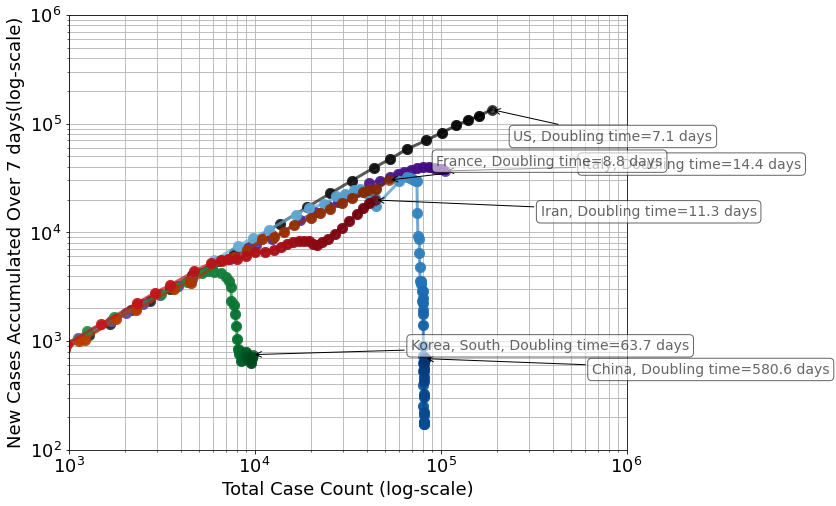

In [133]:
##
countries = ['US', 'Italy', 'China', 'Korea, South', 'France', 'Iran']
# countries = ['China']

states = [] #['California', 'New York', 'Pennsylvania']
cmaps = [ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
window_size=7

##
fig = None
cidx = 0
for country in countries:
    assert(country in all_countries), country
    fig = plot_rate_vs_cases_of_country([country], label=country, 
                                        fig=fig, window_size=window_size, cmap=cmaps[cidx])
    cidx += 1
for state in states:
    fig = plot_rate_vs_cases_of_states([state], label=state, 
                                       fig=fig, window_size=window_size, cmap=cmaps[cidx])
    cidx += 1
fig.gca().axis([10**3, 10**6, 10**2, 10**6])


(1000.0, 1000000.0, 100.0, 1000000.0)

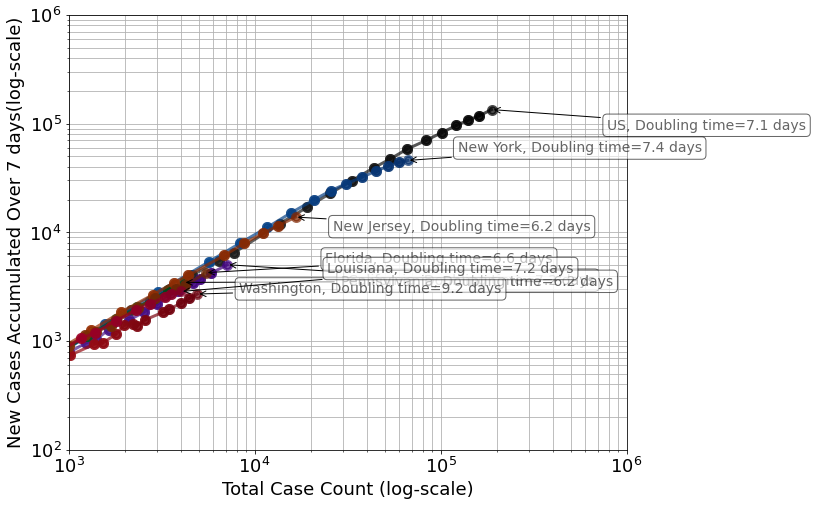

In [134]:
##
countries = ['US']
states = ['California', 'New York', 'Pennsylvania', 'New Jersey', 'Washington', 'Florida', 'Louisiana']
cmaps = [ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
window_size=7

##
fig = None
cidx = 0
for country in countries:
    assert(country in all_countries), country
    fig = plot_rate_vs_cases_of_country([country], label=country, 
                                        fig=fig, window_size=window_size, cmap=cmaps[cidx])
    cidx += 1
    cidx %= len(cmaps)
for state in states:
    assert(state in all_states)
    fig = plot_rate_vs_cases_of_states([state], label=state, 
                                       fig=fig, window_size=window_size, cmap=cmaps[cidx])
    cidx += 1
    cidx %= len(cmaps)
fig.gca().axis([10**3, 10**6, 10**2, 10**6])
